## Single Decision Maker (UNOS) Q-Learning

In [ ]:
# Function to extract the optimal policy from the Q-table
def extract_optimal_policy(Q_table):
    optimal_policy = {}
    for state, actions in Q_table.items():
        optimal_action = max(actions, key=actions.get)  # Action with the highest Q-value
        optimal_policy[state] = optimal_action
    return optimal_policy

# Function to simulate the process using the optimal policy
def simulate_with_optimal_policy(optimal_policy):
    state = initialize_state()  # Start from the initial state
    organs_allocated_over_time = []  # Track cumulative allocations

    for t in range(time_horizon):
        key = state_to_key(state)  # Get state key

        # Get the action from the optimal policy
        if key in optimal_policy:
            action = optimal_policy[key]
        else:
            action = random.choice(actions)  # Fallback to a random action if state not in policy

        # Simulate environment
        next_state, _ = transition(state, action)

        # Track total organs allocated so far
        allocated = total_organs - next_state["organs"]
        organs_allocated_over_time.append(allocated)

        # Update state
        state = next_state

        if state['organs'] <= 0:
            break

    return organs_allocated_over_time

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


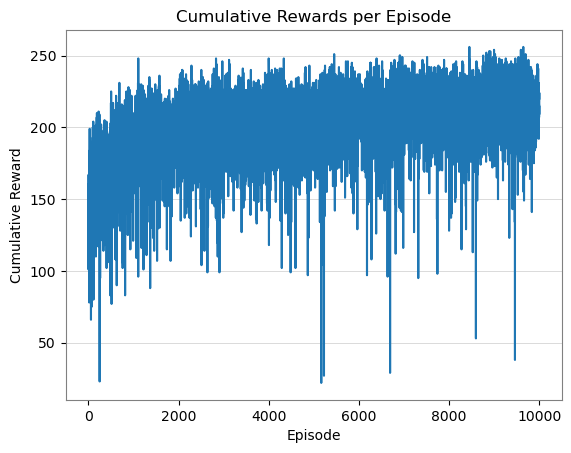

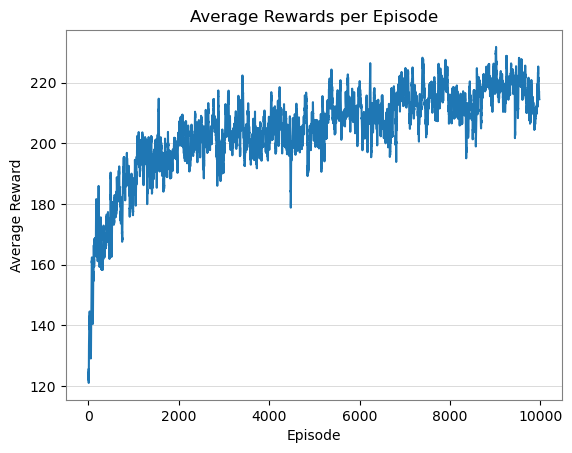

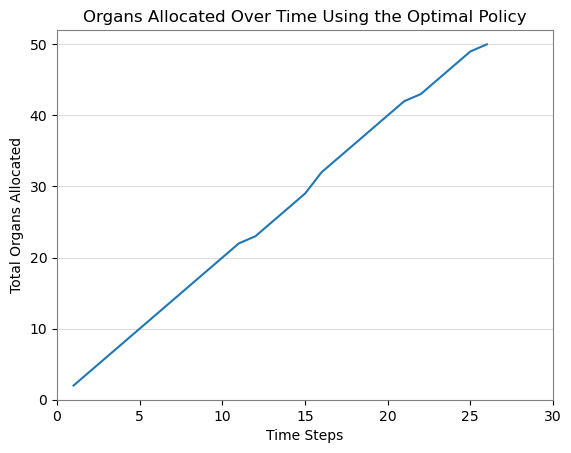

In [224]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000 # Number of Q-learning episodes

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        urgency = sample_urgency(group_id) #for now each group has 1 'new person'
        if urgency > priority:
            allocate[group_id] = 1 #get an organ
        else: 
            allocate[group_id] = 0 #don't get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)


        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break
    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon
    

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.plot(rewards_per_episode)

plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("q-learn-one-per-cumulative.png")
plt.show()

# Visualize the results
window = 20  # Moving average window
avg_rewards = [
    np.mean(rewards_per_episode[i : i + window])
    for i in range(len(rewards_per_episode) - window)
]
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(avg_rewards, label = 'v')
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.title("Average Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.savefig("q-learn-one-per-average.png")
plt.show()
# Extract optimal policy
optimal_policy = extract_optimal_policy(Q_table)

# Simulate using the optimal policy
organs_allocated = simulate_with_optimal_policy(optimal_policy)

# Plot total organs allocated over time
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label='Organs Allocated')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)  
plt.ylim(0, total_organs +2)
plt.title("Organs Allocated Over Time Using the Optimal Policy")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.savefig('q-learn-one-per-org-alloc.png')

plt.show()

## Single Decision Maker
Adding in multiple patients

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


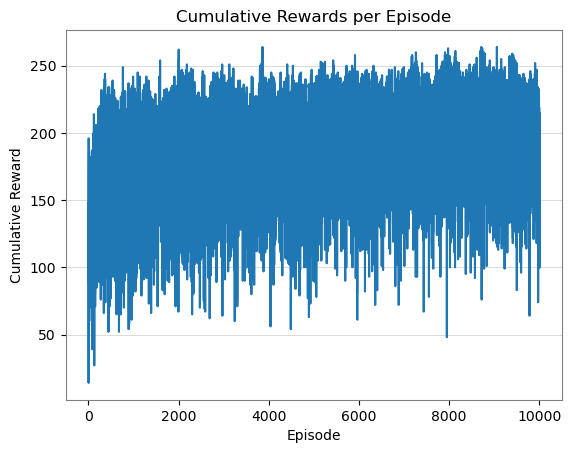

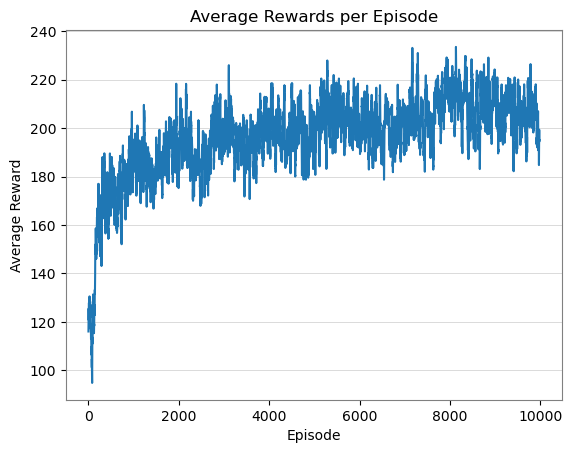

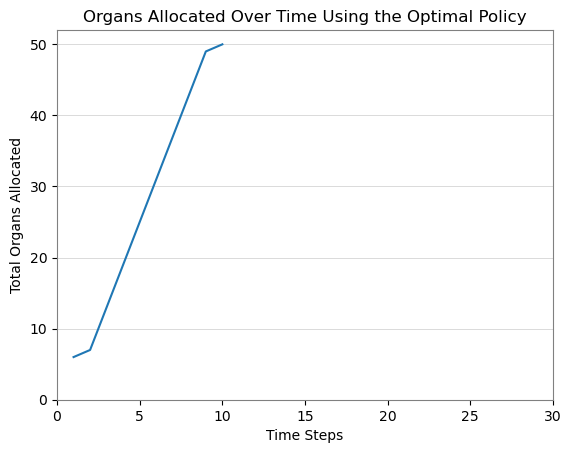

In [223]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000 # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1 }

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        allocate[group_id] = 0 
        for _ in range(patients_per_group[group_id+1]):
            urgency = sample_urgency(group_id) 
            if urgency > priority:
                allocate[group_id] += 1 #get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.plot(rewards_per_episode)

plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("q-learn-one_plus-per-cumulative.png")
plt.show()

# Visualize the results
window = 20  # Moving average window
avg_rewards = [
    np.mean(rewards_per_episode[i : i + window])
    for i in range(len(rewards_per_episode) - window)
]
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(avg_rewards, label = 'v')
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.title("Average Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.savefig("q-learn-one_plus-per-average.png")
plt.show()
# Extract optimal policy
optimal_policy = extract_optimal_policy(Q_table)

# Simulate using the optimal policy
organs_allocated = simulate_with_optimal_policy(optimal_policy)

# Plot total organs allocated over time
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label='Organs Allocated')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)  
plt.ylim(0, total_organs +2)
plt.title("Organs Allocated Over Time Using the Optimal Policy")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.savefig('q-learn-one_plus-per-org-alloc.png')

plt.show()

In [65]:
patients_per_group.keys()

dict_keys([1, 2, 3])

## Mutiple Decision Makers Nash Q-Learning
One per group

In [2]:
def extract_optimal_policy_Nash(Q_table):
    optimal_policy = {}
    for state, actions in Q_table.items():
        optimal_action = np.argmax(actions)  # Find the index (action) with the highest Q-value
        optimal_policy[state] = optimal_action
    return optimal_policy
def simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, transition):
    state = initialize_state()  # Start from the initial state
    organs_allocated_over_time = []  # Track cumulative allocations

    for t in range(time_horizon):
        key = (state["time"], state["organs"])  # Get state key

        # Get the action from the optimal policy
        if key in optimal_policy:
            action = optimal_policy[key]
        else:
            action = random.choice(range(11))  # Fallback to a random action if state not in policy

        # Simulate environment
        next_state, _ = transition(state, [action] * num_groups)

        # Track total organs allocated so far
        allocated = total_organs - next_state["organs"]
        organs_allocated_over_time.append(allocated)

        # Update state
        state = next_state

        if state['organs'] <= 0:
            break

    return organs_allocated_over_time


Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


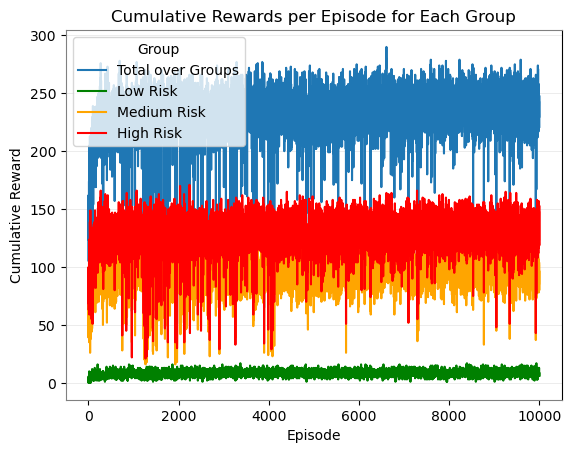

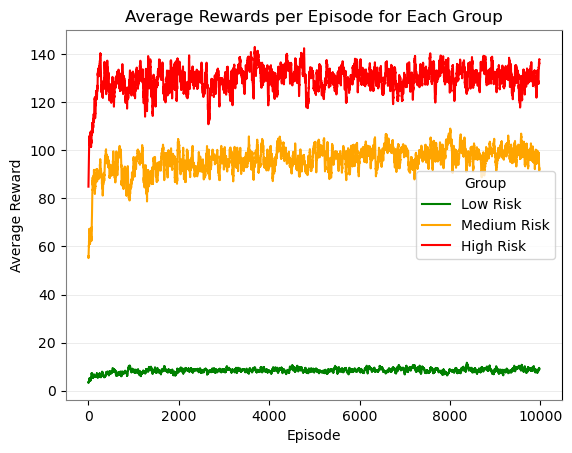

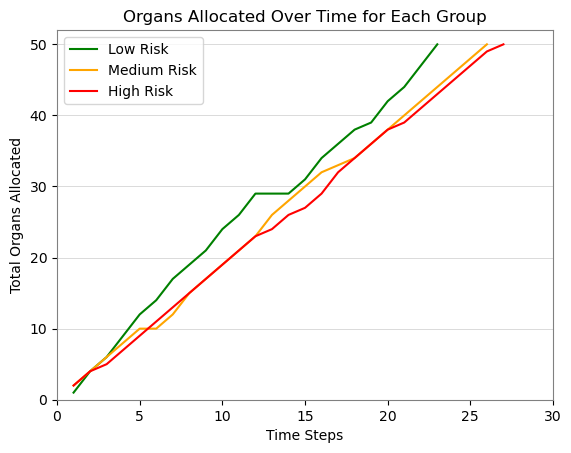

In [242]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000  # Number of Q-learning episodes

epsilon = 0.8
alpha = 0.9
gamma = 0.99

# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function
def decentralized_transition(state, actions):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        urgency = sample_urgency(group_id)
        #print(f"Group {group_id}: Urgency={urgency}, Priority={priority}")
        matched_organs = 0
        if urgency > priority and new_state["organs"] > 0:
            matched_organs = 1
            total_allocation += 1

        #print(f"Group {group_id}: Matched Organs={matched_organs}")
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, state["organs"] - total_allocation)
    #print(f"New State Organs={new_state['organs']}, Rewards={rewards}")
    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

# Q-learning loop       
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition and get rewards
        next_state, rewards = decentralized_transition(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
                - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-one-group-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-one-group-average.png')
plt.show()
for group_id in range(num_groups):
    # Extract the optimal policy for the group
    optimal_policy = extract_optimal_policy_Nash(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    organs_allocated = simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition)

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color = colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-one-group-org-alloc.png')

plt.show()

## Nash Q-Learning 
Mult ppl per group

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


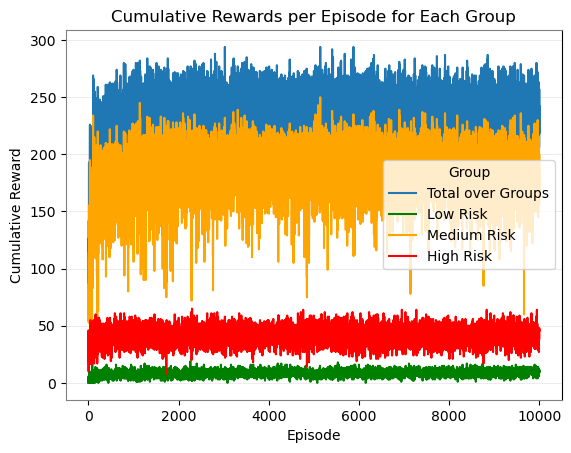

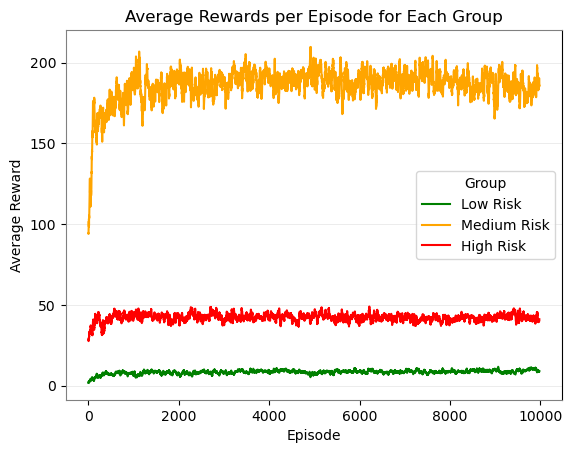

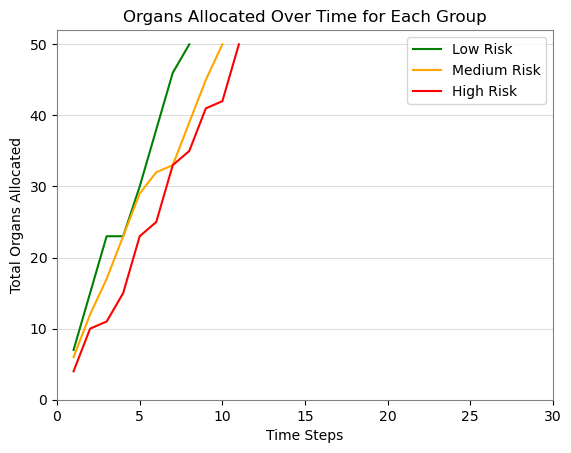

In [244]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000 # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1 }

epsilon = 0.8
alpha = 0.9
gamma = 0.99

# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function with multiple patients per group
def decentralized_transition(state, actions):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        for _ in range(patients_per_group[group_id + 1]):  # Iterate over patients in the group
            urgency = sample_urgency(group_id)
            if urgency > priority and new_state["organs"] > 0:
                matched_organs += 1
                new_state["organs"] -= 1
                total_allocation += 1
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, new_state["organs"])  # Ensure non-negative organ count
    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

# Q-learning loop
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition and get rewards
        next_state, rewards = decentralized_transition(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                q_update - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-multi-group-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-multi-group-average.png')
plt.show()
for group_id in range(num_groups):
    # Extract the optimal policy for the group
    optimal_policy = extract_optimal_policy_Nash(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    organs_allocated = simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition)

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color = colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-multi-group-org-alloc.png')

plt.show()

## Determine distribtions of MELD for each group
Instead of Beta

In [2]:
import pandas as pd
df = pd.read_csv('available_organs.csv')
df = df[df['INIT_MELD_OR_PELD'] == 'MELD']
df.columns
df = df[df['INIT_MELD_PELD_LAB_SCORE'].isna() == False]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113605 entries, 0 to 148138
Data columns (total 33 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ORGAN_TRANSPLANT_ID                113605 non-null  object 
 1   WAITLIST_ID                        113605 non-null  int64  
 2   RECIPIENT_ID                       113605 non-null  int64  
 3   DONOR_ID                           113605 non-null  int64  
 4   RECIPIENT_GENDER                   113605 non-null  object 
 5   RECIPIENT_AGE                      113605 non-null  int64  
 6   DONOR_AGE                          113605 non-null  float64
 7   INIT_MELD_OR_PELD                  113605 non-null  object 
 8   INIT_MELD_PELD_LAB_SCORE           113605 non-null  float64
 9   FINAL_MELD_OR_PELD                 113605 non-null  object 
 10  FINAL_MELD_PELD_LAB_SCORE          113572 non-null  float64
 11  FUNCTIONAL_STATUS_AT_REGISTRATION  113605 no

(array([2.8279e+04, 3.1338e+04, 2.2151e+04, 1.6160e+04, 1.0472e+04,
        4.4950e+03, 6.2300e+02, 7.9000e+01, 6.0000e+00, 2.0000e+00]),
 array([ 6., 13., 20., 27., 34., 41., 48., 55., 62., 69., 76.]),
 <BarContainer object of 10 artists>)

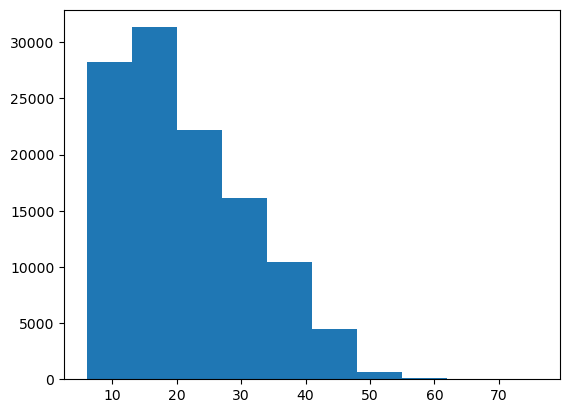

In [3]:
import matplotlib.pyplot as plt

plt.hist(df['INIT_MELD_PELD_LAB_SCORE'])

In [9]:
MELD = df['INIT_MELD_PELD_LAB_SCORE']


# Create the three groups
low_risk = MELD[MELD <= 9]
medium_risk = MELD[(MELD > 9) & (MELD < 40)]
high_risk = MELD[MELD >= 40]

# Output the size of each group
low_risk_size = len(low_risk)
medium_risk_size = len(medium_risk)
high_risk_size = len(high_risk)

(low_risk_size, medium_risk_size, high_risk_size)


(15467, 91771, 6367)

In [151]:
#Get proportions
total = low_risk_size + medium_risk_size + high_risk_size
risks = [low_risk_size, medium_risk_size, high_risk_size]
for risk in risks:
    print(f"{risk/total:.3f}")

0.136
0.808
0.056


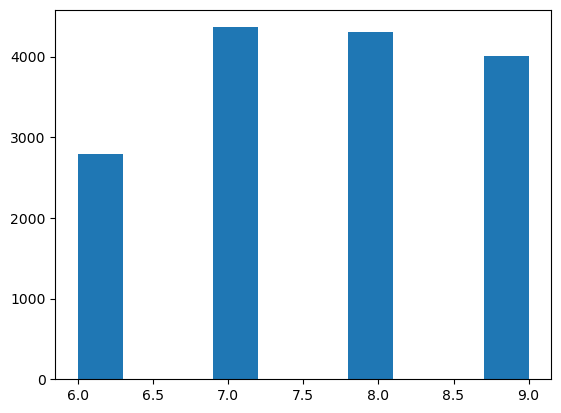

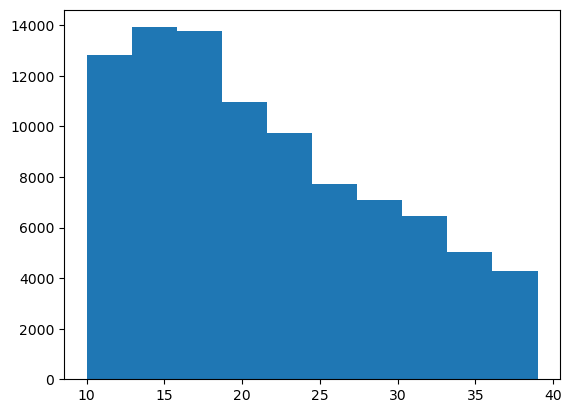

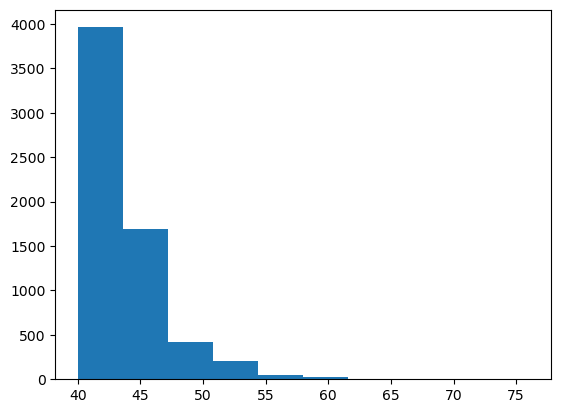

In [ ]:
risks = [low_risk, medium_risk, high_risk]
for risk in risks:
    plt.hist(risk)
    plt.show()

In [12]:
import numpy as np
from scipy.stats import gamma, beta, norm, expon, kstest
from scipy.stats import weibull_min, lognorm, uniform, pareto
import matplotlib.pyplot as plt

# Define distributions to test
distributions = {
    'Gamma': gamma,
    'Beta': beta,
    'Exponential': expon,
    #'Normal': norm
}

additional_distributions = {
    'Weibull': weibull_min,
    'Log-Normal': lognorm,
    'Pareto': pareto,
    'Uniform': uniform
}

# Combine existing and new distributions
all_distributions = {**distributions, **additional_distributions}

# Function to fit distributions and evaluate goodness of fit
def fit_and_evaluate(data, group_name):
    results = {}
    for dist_name, dist in distributions.items():
        try:
            # Fit the distribution to the data
            params = dist.fit(data)
            
            # Perform Kolmogorov-Smirnov test
            ks_stat, ks_pvalue = kstest(data, dist.cdf, args=params)
            
            # Store the results
            results[dist_name] = {
                'params': params,
                'ks_stat': ks_stat,
                'ks_pvalue': ks_pvalue
            }
        except Exception as e:
            results[dist_name] = {'error': str(e)}
    
    # Determine the best fit based on KS statistic
    best_fit = min(results.items(), key=lambda x: x[1]['ks_stat'] if 'ks_stat' in x[1] else float('inf'))
    print(f"Best fit for {group_name}: {best_fit[0]} (KS Statistic={best_fit[1]['ks_stat']:.4f})")
    
    # Plot the histogram and fitted PDF for the best fit
    best_dist_name, best_dist_metrics = best_fit
    best_dist = distributions[best_dist_name]
    params = best_dist_metrics['params']
    
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=30, density=True, alpha=0.5, label=f'{group_name} Data')
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, best_dist.pdf(x, *params), label=f'Best Fit: {best_dist_name}', color='red')
    plt.title(f'{group_name} Group - Best Fitting Distribution')
    plt.xlabel('MELD Score')
    plt.ylabel('Density')
    plt.legend()
    plt.grid()
    plt.show()
    
    return results

# Fit and evaluate distributions for each group
low_risk_results = fit_and_evaluate(low_risk, 'Low Risk')
medium_risk_results = fit_and_evaluate(medium_risk, 'Medium Risk')
high_risk_results = fit_and_evaluate(high_risk, 'High Risk')


NameError: name 'low_risk' is not defined

In [13]:
from scipy.stats import gamma, beta, norm, expon, kstest
from scipy.stats import weibull_min, lognorm, uniform, pareto

In [104]:
#Low
normal_params = norm.fit(low_risk)
mean, SD = normal_params
print('Low Risk')
print(f"Normal Distribution Parameters:")
print(f"  Mean: {mean}")
print(f"  SD: {SD}\n")

#Med
beta_params = beta.fit(medium_risk)  
a, b, loc, scale = beta_params
print('Med Risk')
print(f"Beta Distribution Parameters:")
print(f"  Alpha (a): {a}")
print(f"  Beta (b): {b}")
print(f"  Location (loc): {loc}")
print(f"  Scale (scale): {scale}\n")

#High
exponential_params = expon.fit(high_risk) 
loc, scale = exponential_params
print('High Risk')
print(f"Exponential Distribution Parameters:")
print(f"  Location (loc): {loc}")
print(f"  Scale (scale): {scale}")



Low Risk
Normal Distribution Parameters:
  Mean: 7.615633283765436
  SD: 1.0560040212610342

Med Risk
Beta Distribution Parameters:
  Alpha (a): 0.9160467465251303
  Beta (b): 1.5615957667383893
  Location (loc): 9.999999999999998
  Scale (scale): 29.609204134339365

High Risk
Exponential Distribution Parameters:
  Location (loc): 40.0
  Scale (scale): 3.4077273441181077


In [54]:
norm.fit(low_risk)

(7.615633283765436, 1.0560040212610342)

## Try to define new sampling urgency functions

In [135]:
from scipy.stats import gamma, beta, expon

# Define distribution parameters for each group
low_risk_params = {'shape': 702.834708717764, 'loc': -20.501880532369725, 'scale': 0.04000494359551243}
med_risk_params = {'a': 0.9160467465251303, 'b': 1.5615957667383893, 'loc': 9.999999999999998, 'scale': 29.609204134339365}
high_risk_params = {'loc': 40.0, 'scale': 3.4077273441181077}

# Theoretical min and max values for normalization
low_risk_range = (0, gamma.ppf(0.99, low_risk_params['shape'], loc=low_risk_params['loc'], scale=low_risk_params['scale']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        urgency = gamma.rvs(low_risk_params['shape'], loc=low_risk_params['loc'], scale=low_risk_params['scale'])
        scaled_urgency = scale_to_range(urgency, *low_risk_range)
    elif group_id == 1:  # Medium Risk
        urgency = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        scaled_urgency = scale_to_range(urgency, *med_risk_range)
    elif group_id == 2:  # High Risk
        urgency = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        scaled_urgency = scale_to_range(urgency, *high_risk_range)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return 10 - np.clip(np.round(scaled_urgency, 2), 0, 10)  # Ensure the result is within [0, 10]

# Example: Sample and scale urgencies for all groups
for group_id in range(3):
    urgencies = [sample_urgency(group_id) for _ in range(5)]
    print(f"Group {group_id} Urgencies: {urgencies}")


Group 0 Urgencies: [2.3200000000000003, 0.0, 1.7100000000000009, 0.6099999999999994, 2.05]
Group 1 Urgencies: [7.45, 7.43, 7.79, 8.4, 4.91]
Group 2 Urgencies: [9.04, 8.73, 9.39, 8.65, 4.83]


In [112]:
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408}


# Theoretical min and max values for normalization
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        urgency = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        scaled_urgency = scale_to_range(urgency, *low_risk_range)
    elif group_id == 1:  # Medium Risk
        urgency = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        scaled_urgency = scale_to_range(urgency, *med_risk_range)
    elif group_id == 2:  # High Risk
        urgency = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        scaled_urgency = scale_to_range(urgency, *high_risk_range)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return 10 - np.clip(np.round(scaled_urgency, 2), 0, 10)  # Ensure the result is within [0, 10]

# Example: Sample and scale urgencies for all groups
for group_id in range(3):
    urgencies = [sample_urgency(group_id) for _ in range(5)]
    print(f"Group {group_id} Urgencies: {urgencies}")

Group 0 Urgencies: [6.67, 6.140000000000001, 2.2300000000000004, 6.71, 7.029999999999999]
Group 1 Urgencies: [2.4400000000000004, 3.1100000000000003, 7.67, 1.8000000000000007, 9.95]
Group 2 Urgencies: [9.54, 6.62, 9.79, 7.59, 9.54]


In [4]:
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408}

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

for group_id in range(3):
    urgencies = [sample_urgency(group_id) for _ in range(5)]
    print(f"Group {group_id} Urgencies: {urgencies}")


Group 0 Urgencies: [0.6, 3.61, 3.16, 2.29, 2.15]
Group 1 Urgencies: [3.53, 5.02, 3.01, 6.97, 5.13]
Group 2 Urgencies: [7.18, 6.2, 6.69, 6.1, 6.32]


## Nash Q-learn
Multiple patient and using MELD distributions

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


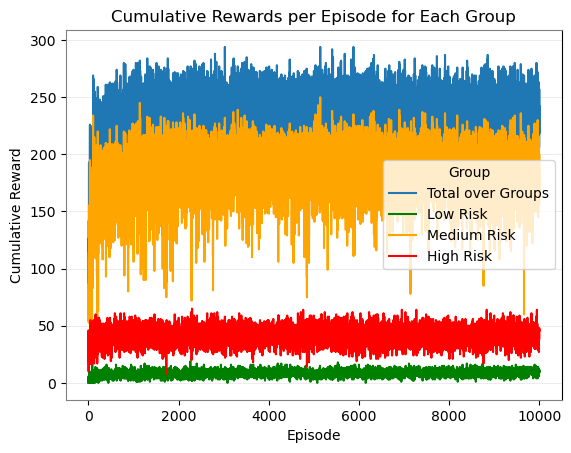

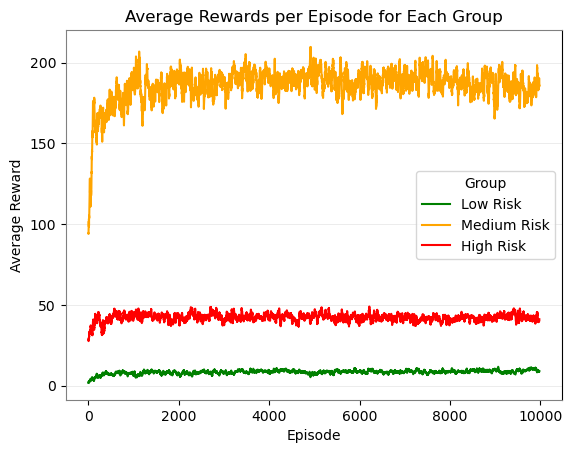

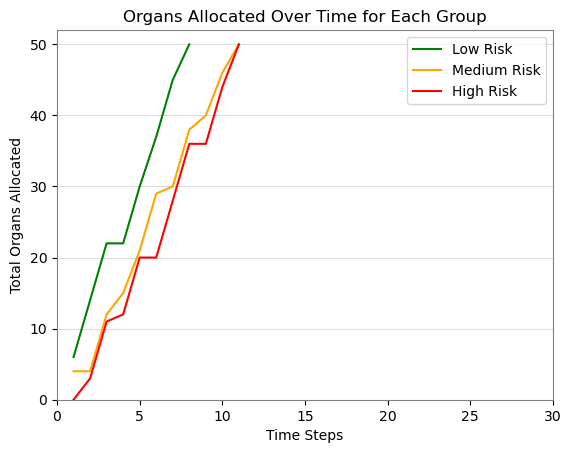

In [ ]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000 # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1}

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

# Sample urgency
# Define urgency sampling function
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408} #exp

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        allocate[group_id] = 0 
        for _ in range(patients_per_group[group_id+1]):
            urgency = sample_urgency(group_id) 
            if urgency > priority:
                allocate[group_id] += 1 #get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-one-group-meld-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-one-group-meld-average.png')
plt.show()
for group_id in range(num_groups):
    # Extract the optimal policy for the group
    optimal_policy = extract_optimal_policy_Nash(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    organs_allocated = simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition)

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color = colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-one-group-meld-org-alloc.png')

plt.show()

## Nash Q-Learn with new sampling dists

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


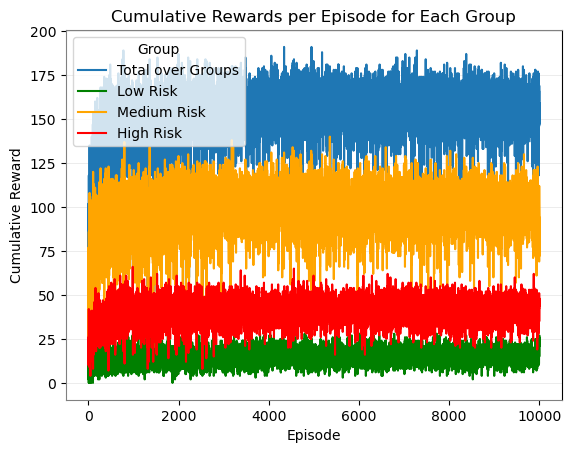

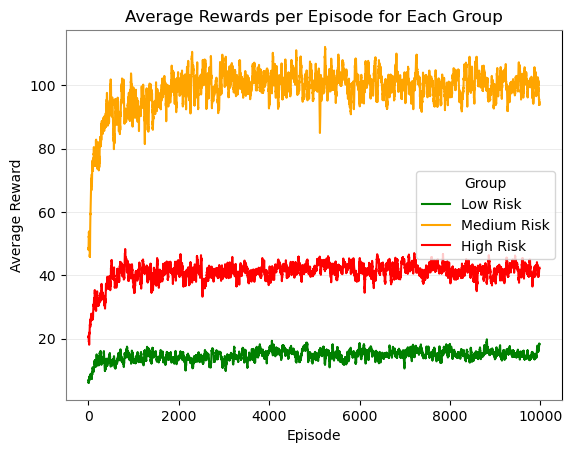

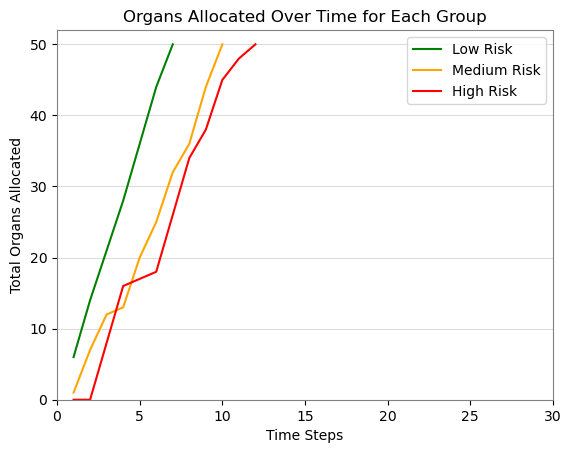

In [246]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000  # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1}

epsilon = 0.8
alpha = 0.9
gamma = 0.99

# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Sample urgency
# Define urgency sampling function
from scipy.stats import norm, beta, expon

# Define distribution parameters for each group
low_risk_params = {'mean': 7.6, 'std': 1.056} #Normal
med_risk_params = {'a': 0.916, 'b': 1.562, 'loc': 10.0, 'scale': 29.609} #Beta
high_risk_params = {'loc': 40.0, 'scale': 3.408}

# Theoretical ranges based on MELD scores
low_risk_range = (norm.ppf(0.01, loc=low_risk_params['mean'], scale=low_risk_params['std']),
                  norm.ppf(0.99, loc=low_risk_params['mean'], scale=low_risk_params['std']))
med_risk_range = (med_risk_params['loc'], med_risk_params['loc'] + med_risk_params['scale'])
high_risk_range = (high_risk_params['loc'], high_risk_params['loc'] + expon.ppf(0.99, scale=high_risk_params['scale']))

def scale_to_range(value, min_val, max_val, target_min=0, target_max=10):
    """Scale a value to a specified range."""
    return target_min + (value - min_val) * (target_max - target_min) / (max_val - min_val)

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]


# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function with multiple patients per group
def decentralized_transition(state, actions):
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        for _ in range(patients_per_group[group_id + 1]):  # Iterate over patients in the group
            urgency = sample_urgency(group_id)
            if urgency > priority and new_state["organs"] > 0:
                matched_organs += 1
                new_state["organs"] -= 1
                total_allocation += 1
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        rewards[group_id] = matched_organs * priority

    new_state["organs"] = max(0, new_state["organs"])  # Ensure non-negative organ count
    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}

# Q-learning loop
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition and get rewards
        next_state, rewards = decentralized_transition(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                q_update - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-mult-group-meld-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-mult-group-meld-average.png')
plt.show()
for group_id in range(num_groups):
    # Extract the optimal policy for the group
    optimal_policy = extract_optimal_policy_Nash(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    organs_allocated = simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition)

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color = colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-mult-group-meld-org-alloc.png')

plt.show()


## Single Q MELD multi ppl

Episode 1/10000
Episode 501/10000
Episode 1001/10000
Episode 1501/10000
Episode 2001/10000
Episode 2501/10000
Episode 3001/10000
Episode 3501/10000
Episode 4001/10000
Episode 4501/10000
Episode 5001/10000
Episode 5501/10000
Episode 6001/10000
Episode 6501/10000
Episode 7001/10000
Episode 7501/10000
Episode 8001/10000
Episode 8501/10000
Episode 9001/10000
Episode 9501/10000


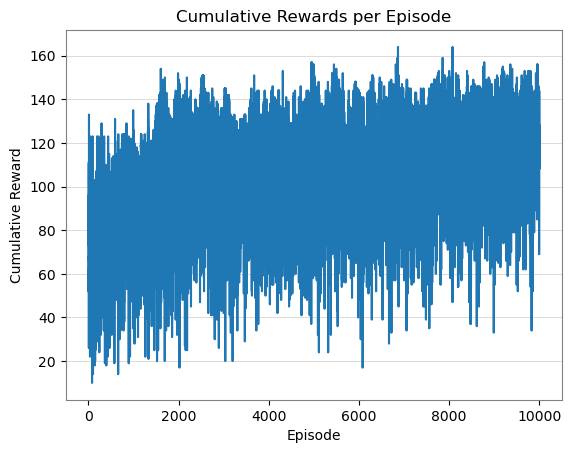

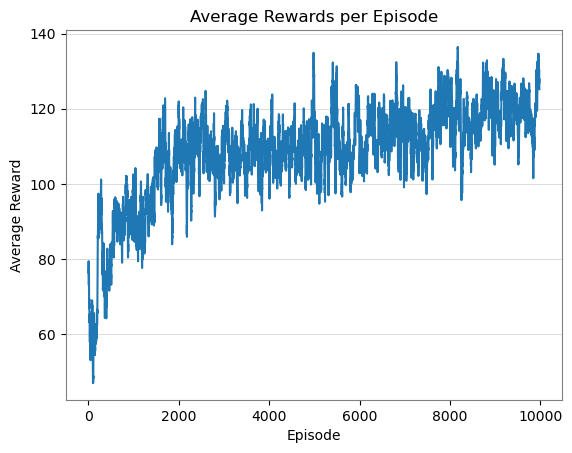

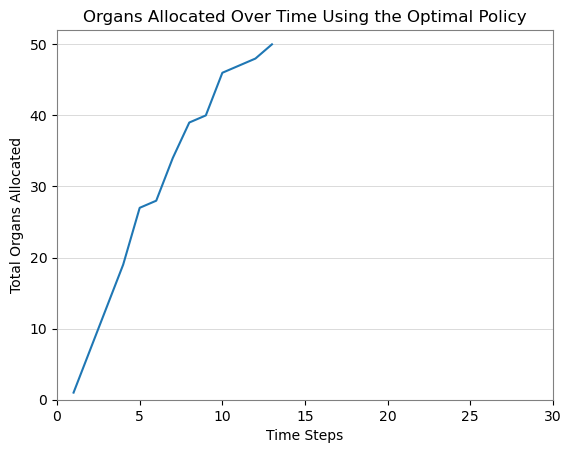

In [247]:
# Updated implementation with corrected state space (matched organs)
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 50  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 10000 # Number of Q-learning episodes

patients_per_group = {1: 2, 2: 5, 3:1 }

epsilon = 0.8
alpha = 0.9
gamma = 0.99
# Patient group parameters


# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    #need to do allocation 
    for group_id, priority in enumerate(action): #for each group id sample loop through get num patients for each patients sample urgency 
        allocate[group_id] = 0 
        for _ in range(patients_per_group[group_id+1]):
            urgency = sample_urgency(group_id) 
            if urgency > priority:
                allocate[group_id] += 1 #get an organ
    
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organ count
        "patient_groups": [],
    }
    
    reward = 0
    
    
    # Update matched organs for each group based on the action
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        if matched_organs > 0: 
            reward += matched_organs*action[group_id]
    
    if state['organs'] < 0: 
        reward -= 200
    

    return new_state, reward


# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0

    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")


# Plot cumulative rewards per episode
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.plot(rewards_per_episode)

plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("q-learn-one_plus-meld-per-cumulative.png")
plt.show()

# Visualize the results
window = 20  # Moving average window
avg_rewards = [
    np.mean(rewards_per_episode[i : i + window])
    for i in range(len(rewards_per_episode) - window)
]
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(avg_rewards, label = 'v')
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.title("Average Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.savefig("q-learn-one_plus-meld-per-average.png")
plt.show()
# Extract optimal policy
optimal_policy = extract_optimal_policy(Q_table)

# Simulate using the optimal policy
organs_allocated = simulate_with_optimal_policy(optimal_policy)

# Plot total organs allocated over time
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label='Organs Allocated')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)  
plt.ylim(0, total_organs +2)
plt.title("Organs Allocated Over Time Using the Optimal Policy")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.savefig('q-learn-one_plus-meld-per-org-alloc.png')

plt.show()

## Single Q ppl keep coming

Episode 1/100


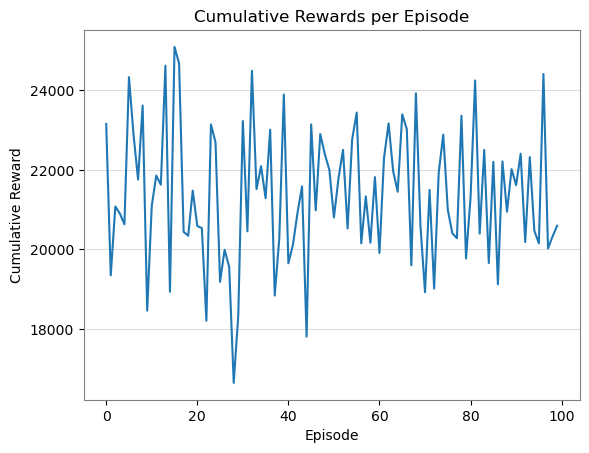

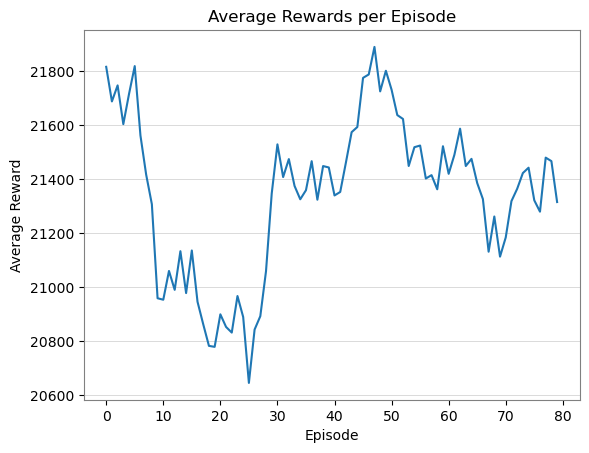

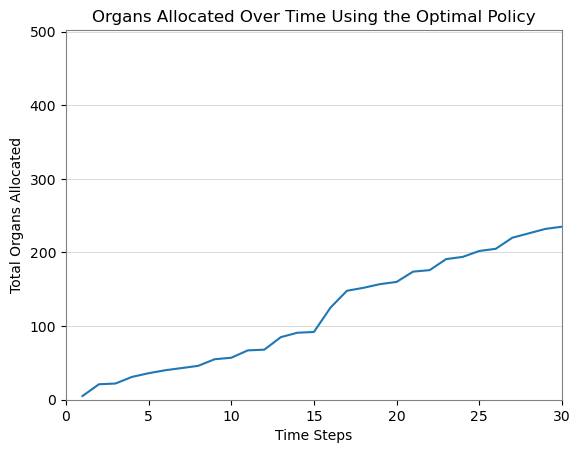

In [ ]:
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000 # Number of Q-learning episodes

group_lambdas = [3, 5, 1]  # Mean number of new patients for each group


patients_per_group = {1: 1, 2: 1, 3:1 }

epsilon = 0.8
alpha = 0.1
gamma = 1
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

# Define urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    urgency_levels = []
    reward = 0  # Start reward as 0
    
    # Allocate organs based on action and urgency
    for group_id, priority in enumerate(action):
        allocate[group_id] = 0
        for _ in range(patients_per_group[group_id + 1]):
            urgency = sample_urgency(group_id)
            urgency_levels.append(urgency)
            if urgency > priority:
                allocate[group_id] += 1  # Organ is matched to a patient
    
    # Create the new state
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organs
        "urgency_levels": urgency_levels,  # Update urgency levels
        "patient_groups": [],
    }

    # Update patient group sizes and matched organs
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        new_patients = np.random.poisson(lam=group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients
        patients_per_group[group_id + 1] -= matched_organs

        # Reward for allocating organs to patients
        reward += matched_organs * (10 + group_id)  # Add weight to group priority
    
    # Reward efficient use of organs
    reward += 5 * (total_organs - new_state["organs"])  # Encourage organ usage
    
    # Penalize for unallocated high-priority patients
    if patients_per_group[3] > 0 and allocate[2] == 0:  # High-priority group is unallocated
        reward -= 50  # High penalty for neglecting high-priority patients
        reward -= 50 * patients_per_group[3]
    
    # Penalize for unused organs as time progresses
    if state['organs'] > 0 and state['time'] == time_horizon - 1:  # Organs unused at end
        reward -= 100  # Heavy penalty for unused organs at the end of the time horizon
    
    # Optional: Penalize premature depletion of organs
    if new_state["organs"] == 0 and new_state["time"] < time_horizon:
        reward -= 100  # Harsh penalty for running out of organs too early
    
    if patients_per_group[3] > 0 and allocate[2] > 0:  # High-priority patients matched
        reward += 50  # High reward for matching high-priority patients


    return new_state, reward



# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0
    patients_per_group = {1: 1, 2: 1, 3:1 } #reinitialize patients


    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)
        

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    if episode > 100 and rewards_per_episode[-1] < np.mean(rewards_per_episode[-50:]):
        epsilon = min(0.2, epsilon + 0.05)  # Mild exploration boost if rewards stagnate
    else:
        epsilon = max(0.1, epsilon * 0.999)  # Very slow decay
    alpha = max(0.01, alpha * 0.99)

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")

# Plot cumulative rewards per episode
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.plot(rewards_per_episode)

plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("q-learn-ppl-add-per-cumulative.png")
plt.show()

# Visualize the results
window = 20  # Moving average window
avg_rewards = [
    np.mean(rewards_per_episode[i : i + window])
    for i in range(len(rewards_per_episode) - window)
]
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(avg_rewards, label = 'v')
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.title("Average Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.savefig("q-learn-ppl-add-per-average.png")
plt.show()
# Extract optimal policy
optimal_policy = extract_optimal_policy(Q_table)

# Simulate using the optimal policy
organs_allocated = simulate_with_optimal_policy(optimal_policy)

# Plot total organs allocated over time
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label='Organs Allocated')

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)  
plt.ylim(0, total_organs +2)
plt.title("Organs Allocated Over Time Using the Optimal Policy")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.savefig('q-learn-ppl-add-per-org-alloc.png')

plt.show()

## Single Q ppl keep coming MELD

In [19]:
# Re-initialize environment parameters
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 2000 # Number of Q-learning episodes

group_lambdas = [3, 5, 1]  # Mean number of new patients for each group


patients_per_group = {1: 1, 2: 1, 3:1 }

epsilon = 0.8
alpha = 0.1
gamma = 1
# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}


# Patient group parameters
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Action space: Prioritization levels for all groups (bounded [0, 10])
actions = list(itertools.product(range(11), repeat=num_groups))  # Joint actions

# Q-table
Q_table = {}

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]


# Define state-to-key helper based on new representation
def state_to_key(state):
    return (
        state["time"],  # Current time step
        state["organs"],  # Remaining organ count
        tuple(group["matched_organs"] for group in state["patient_groups"]),  # Organs matched in the previous step
    )

# Define initial state (joint state space)
def initialize_state():
    
    return {
        "time": 0,  # Start at time step 0
        "organs": total_organs,  # Initial organ supply
        "patient_groups": [
            {"matched_organs": 0}  # Initially no organs matched for each group
            for _ in range(num_groups)
        ],
    }

# Updated transition model based on matched organs
def transition(state, action):
    allocate = {}
    urgency_levels = []
    reward = 0  # Start reward as 0
    
    # Allocate organs based on action and urgency
    for group_id, priority in enumerate(action):
        allocate[group_id] = 0
        for _ in range(patients_per_group[group_id + 1]):
            urgency = sample_urgency(group_id)
            urgency_levels.append(urgency)
            if urgency > priority:
                allocate[group_id] += 1  # Organ is matched to a patient
    
    # Create the new state
    new_state = {
        "time": state["time"] + 1,  # Increment time step
        "organs": max(0, state["organs"] - sum(allocate.values())),  # Update remaining organs
        "urgency_levels": urgency_levels,  # Update urgency levels
        "patient_groups": [],
    }

    # Update patient group sizes and matched organs
    for group_id, matched_organs in allocate.items():
        new_state["patient_groups"].append({"matched_organs": matched_organs})
        new_patients = np.random.poisson(lam=group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients
        patients_per_group[group_id + 1] -= matched_organs

        # Reward for allocating organs to patients
        reward += matched_organs * (10 + group_id)  # Add weight to group priority
    
    # Reward efficient use of organs
    reward += 5 * (total_organs - new_state["organs"])  # Encourage organ usage
    
    # Penalize for unallocated high-priority patients
    if patients_per_group[3] > 0 and allocate[2] == 0:  # High-priority group is unallocated
        reward -= 50  # High penalty for neglecting high-priority patients
        reward -= 50 * patients_per_group[3]
    
    # Penalize for unused organs as time progresses
    if state['organs'] > 0 and state['time'] == time_horizon - 1:  # Organs unused at end
        reward -= 100  # Heavy penalty for unused organs at the end of the time horizon
    
    # Optional: Penalize premature depletion of organs
    if new_state["organs"] == 0 and new_state["time"] < time_horizon:
        reward -= 100  # Harsh penalty for running out of organs too early
    
    if patients_per_group[3] > 0 and allocate[2] > 0:  # High-priority patients matched
        reward += 50  # High reward for matching high-priority patients


    return new_state, reward



# Initialize Q-table dynamically
def initialize_Q(state):
    key = state_to_key(state)
    if key not in Q_table:
        Q_table[key] = {a: 0 for a in actions}

# Re-run Q-learning loop with the corrected state representation
rewards_per_episode = []

for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()  # Start from the initial state
    total_reward = 0
    patients_per_group = {1: 1, 2: 1, 3:1 } #reinitialize patients


    for t in range(time_horizon):
        # Convert state to key and initialize Q-table entry if needed
        #print(state)
        key = state_to_key(state)
        initialize_Q(state)
        

        # Choose an action (epsilon-greedy policy)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)  # Explore
        else:
            action = max(Q_table[key], key=Q_table[key].get)  # Exploit
            
        #print(f"action is {action}")

        # Simulate environment
        next_state, reward = transition(state, action)
        next_key = state_to_key(next_state)
        initialize_Q(next_state)  # Initialize next state in Q-table if needed

        # Update Q-value using the Bellman equation
        best_next_action = max(Q_table[next_key], key=Q_table[next_key].get)
        Q_table[key][action] += alpha * (
            reward + gamma * Q_table[next_key][best_next_action] - Q_table[key][action]
        )
        #print(Q_table[next_key][best_next_action])

        state = next_state
        total_reward += reward
        
        if state['organs'] <= 0: 
            #print("used up all the organs")
            break

    rewards_per_episode.append(total_reward)
    if episode > 100 and rewards_per_episode[-1] < np.mean(rewards_per_episode[-50:]):
        epsilon = min(0.2, epsilon + 0.05)  # Mild exploration boost if rewards stagnate
    else:
        epsilon = max(0.1, epsilon * 0.999)  # Very slow decay
    alpha = max(0.01, alpha * 0.99)

# Convert Q-table to DataFrame for analysis
policy_df = pd.DataFrame.from_dict(Q_table, orient="index")

# Plot cumulative rewards per episode
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.plot(rewards_per_episode)

plt.title("Cumulative Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.savefig("q-learn-ppl-add-per-meld-cumulative.png")
plt.show()

# Visualize the results
window = 20  # Moving average window
avg_rewards = [
    np.mean(rewards_per_episode[i : i + window])
    for i in range(len(rewards_per_episode) - window)
]
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)
plt.plot(avg_rewards, label = 'v')
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
plt.title("Average Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.savefig("q-learn-ppl-add-per-meld-average.png")
plt.show()


Episode 1/2000
Episode 501/2000
Episode 1001/2000
Episode 1501/2000


KeyboardInterrupt: 

## Nash ppl keep coming

Episode 1/5000
Episode 501/5000
Episode 1001/5000
Episode 1501/5000
Episode 2001/5000
Episode 2501/5000
Episode 3001/5000
Episode 3501/5000
Episode 4001/5000
Episode 4501/5000


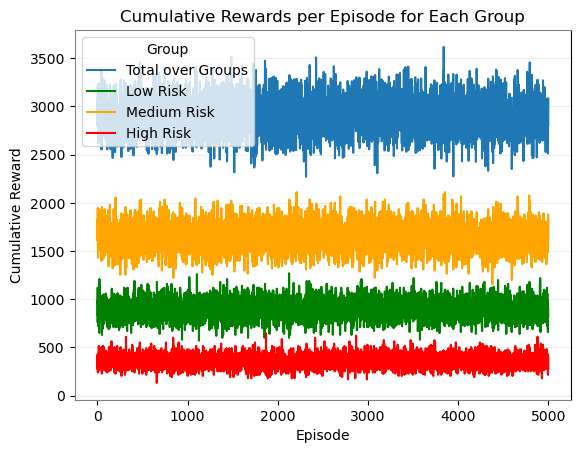

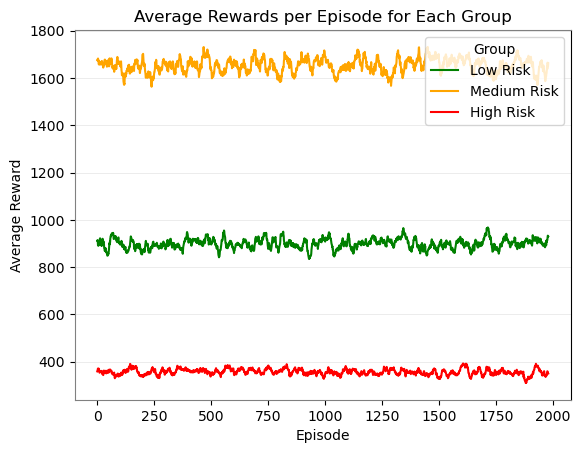

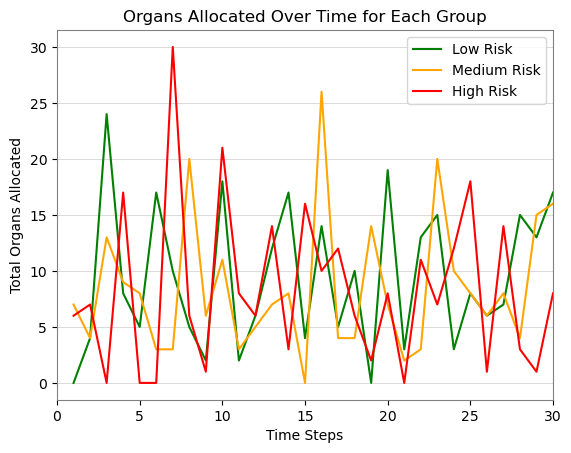

In [27]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000 # Number of Q-learning episodes


patients_per_group = {1: 1, 2: 1, 3: 1}  # Initial patients per group
epsilon = 0.8  # Exploration probability
alpha = 0.9  # Learning rate
gamma = 0.99  # Discount factor

# Patient group parameters
group_lambdas = [3, 5, 1]  # Mean number of new patients for each group
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

# Urgency sampling function
def sample_urgency(group_id):
    alpha, beta = alpha_params[group_id], beta_params[group_id]
    return np.round(np.random.beta(alpha, beta) * 10, 2)  # Scaled urgency [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function with random patient arrivals
def decentralized_transition_with_arrival(state, actions):
    """Transition function with patient arrivals."""
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        # Iterate over patients currently in the group
        for _ in range(patients_per_group[group_id + 1]):
            urgency = sample_urgency(group_id)
            if urgency > priority and new_state["organs"] > 0:
                matched_organs += 1
                new_state["organs"] -= 1
                total_allocation += 1

        # Add new patients to the group based on Poisson arrivals
        new_patients = np.random.poisson(group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients

        # Update patient group size after matching
        patients_per_group[group_id + 1] -= matched_organs
        new_state["patient_groups"].append({"matched_organs": matched_organs})

        # Reward for matched organs
        rewards[group_id] = matched_organs * (10 + group_id)  # Priority-weighted reward

    # Ensure organs count is non-negative
    new_state["organs"] = max(0, new_state["organs"])

    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    """Compute Nash equilibrium actions for each group."""
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}
def initialize_state_in_q_table(group_id, state):
    """Ensure that a given state exists in the Q-table."""
    if state not in group_Q_tables[group_id]:
        group_Q_tables[group_id][state] = [0] * 11  # Initialize all actions with Q-values of 0


# Nash Q-learning loop
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition with patient arrivals
        next_state, rewards = decentralized_transition_with_arrival(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])

            # Ensure states exist in Q-table
            initialize_state_in_q_table(group_id, group_state)
            initialize_state_in_q_table(group_id, next_group_state)

            # Compute Q-value update
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                q_update - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    # Decay epsilon
    epsilon = max(0.1, epsilon * 0.99)
# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-ppl-add-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-ppl-add-average.png')
plt.show()

for group_id in range(num_groups):
    # Extract the optimal policy for the group
    def extract_optimal_policy(group_Q_table):
        """Extract the optimal policy for a group based on its Q-table."""
        optimal_policy = {}
        for state in group_Q_table:
            optimal_policy[state] = np.argmax(group_Q_table[state])  # Best action
        return optimal_policy

    optimal_policy = extract_optimal_policy(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    def simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, transition_func):
        """Simulate organ allocation using an optimal policy for a single group."""
        state = initialize_state()
        organs_allocated = []
        for t in range(time_horizon):
            group_state = (state["time"], state["organs"])
            if group_state in optimal_policy:
                action = optimal_policy[group_state]
            else:
                action = 0  # Default action if the state is missing

            # Perform the transition
            next_state, _ = transition_func(state, [action] * num_groups)  # Apply action for the group
            organs_allocated.append(state["organs"] - next_state["organs"])  # Track organs allocated in this step
            state = next_state

        return organs_allocated

    organs_allocated = simulate_with_optimal_policy_per_group(
        optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition_with_arrival
    )

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color=colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
#plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-ppl-add-org-alloc.png')

plt.show()



## Nash ppl add MELD

Episode 1/5000
Episode 501/5000
Episode 1001/5000
Episode 1501/5000
Episode 2001/5000
Episode 2501/5000
Episode 3001/5000
Episode 3501/5000
Episode 4001/5000
Episode 4501/5000


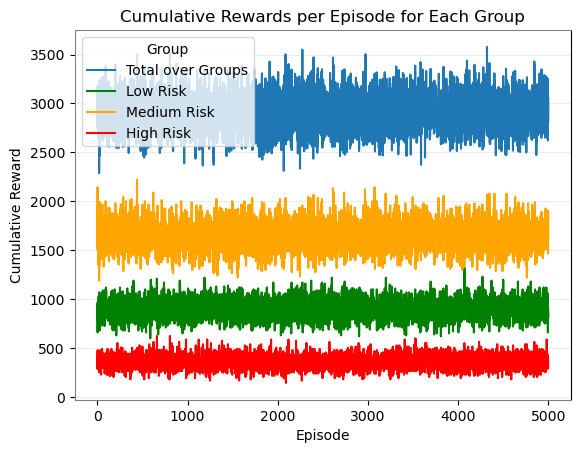

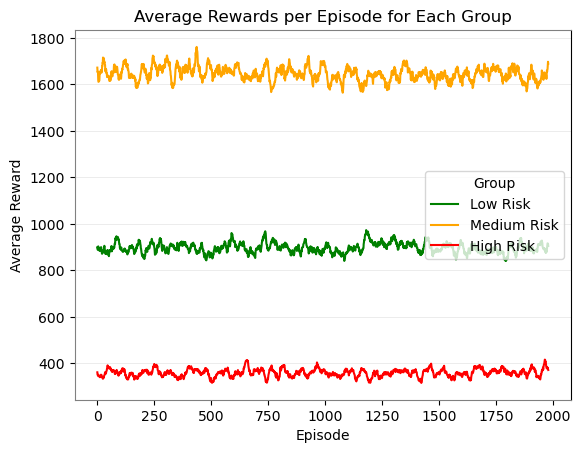

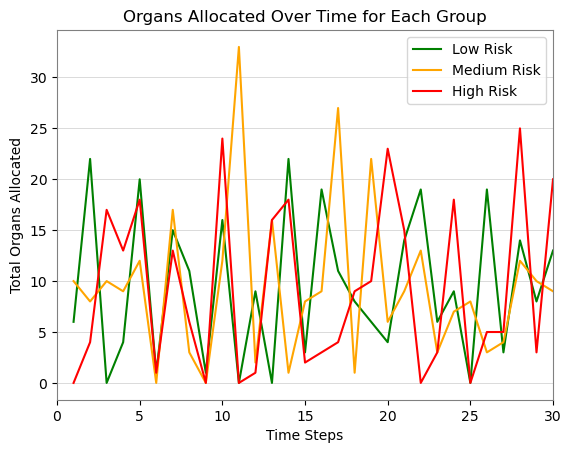

In [28]:
import itertools
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# Environment parameters
num_groups = 3  # Patient groups: Low Risk, Medium Risk, High Risk
total_organs = 500  # Initial organ supply
time_horizon = 30  # Ischemic time limit (discrete time steps)
num_episodes = 5000 # Number of Q-learning episodes


patients_per_group = {1: 1, 2: 1, 3: 1}  # Initial patients per group
epsilon = 0.8  # Exploration probability
alpha = 0.9  # Learning rate
gamma = 0.99  # Discount factor

# Patient group parameters
group_lambdas = [3, 5, 1]  # Mean number of new patients for each group
alpha_params = [5, 25, 9]  # Alpha parameters for urgency Beta distribution
beta_params = [25, 10, 1]  # Beta parameters for urgency Beta distribution

# Initialize Q-tables for each group
group_Q_tables = [
    {(t, organs): [0] * 11 for t in range(time_horizon) for organs in range(total_organs + 1)}
    for _ in range(num_groups)
]

def sample_urgency(group_id):
    if group_id == 0:  # Low Risk
        # Sample from Normal distribution for Low Risk
        meld_score = norm.rvs(loc=low_risk_params['mean'], scale=low_risk_params['std'])
        urgency = scale_to_range(meld_score, *low_risk_range, target_min=0, target_max=5)
    elif group_id == 1:  # Medium Risk
        # Sample from Beta distribution for Medium Risk
        meld_score = beta.rvs(med_risk_params['a'], med_risk_params['b'], loc=med_risk_params['loc'], scale=med_risk_params['scale'])
        urgency = scale_to_range(meld_score, *med_risk_range, target_min=3, target_max=7)
    elif group_id == 2:  # High Risk
        # Sample from Exponential distribution for High Risk
        meld_score = expon.rvs(loc=high_risk_params['loc'], scale=high_risk_params['scale'])
        urgency = scale_to_range(meld_score, *high_risk_range, target_min=6, target_max=10)
    else:
        raise ValueError(f"Invalid group_id: {group_id}")
    
    return np.clip(np.round(urgency, 2), 0, 10)  # Ensure the urgency falls in [0, 10]

# Initialize state
def initialize_state():
    return {
        "time": 0,
        "organs": total_organs,
        "patient_groups": [{"matched_organs": 0} for _ in range(num_groups)],
    }

# Transition function with random patient arrivals
def decentralized_transition_with_arrival(state, actions):
    """Transition function with patient arrivals."""
    new_state = {
        "time": state["time"] + 1,
        "organs": state["organs"],
        "patient_groups": [],
    }
    rewards = [0] * num_groups
    total_allocation = 0

    for group_id, priority in enumerate(actions):
        matched_organs = 0
        # Iterate over patients currently in the group
        for _ in range(patients_per_group[group_id + 1]):
            urgency = sample_urgency(group_id)
            if urgency > priority and new_state["organs"] > 0:
                matched_organs += 1
                new_state["organs"] -= 1
                total_allocation += 1

        # Add new patients to the group based on Poisson arrivals
        new_patients = np.random.poisson(group_lambdas[group_id])
        patients_per_group[group_id + 1] += new_patients

        # Update patient group size after matching
        patients_per_group[group_id + 1] -= matched_organs
        new_state["patient_groups"].append({"matched_organs": matched_organs})

        # Reward for matched organs
        rewards[group_id] = matched_organs * (10 + group_id)  # Priority-weighted reward

    # Ensure organs count is non-negative
    new_state["organs"] = max(0, new_state["organs"])

    return new_state, rewards

# Compute Nash equilibrium
def compute_nash_equilibrium(group_Q_tables, state):
    """Compute Nash equilibrium actions for each group."""
    actions = []
    for group_id in range(num_groups):
        group_state = (state["time"], state["organs"])
        if random.uniform(0, 1) < epsilon:
            action = random.randint(0, 10)  # Explore
        else:
            action = np.argmax(group_Q_tables[group_id][group_state])  # Exploit
        actions.append(action)
    return actions

# Track cumulative rewards
group_rewards_per_episode = {group_id: [] for group_id in range(num_groups)}
def initialize_state_in_q_table(group_id, state):
    """Ensure that a given state exists in the Q-table."""
    if state not in group_Q_tables[group_id]:
        group_Q_tables[group_id][state] = [0] * 11  # Initialize all actions with Q-values of 0


# Nash Q-learning loop
for episode in range(num_episodes):
    if episode % 500 == 0:
        print(f"Episode {episode+1}/{num_episodes}")
    state = initialize_state()
    total_rewards = [0] * num_groups

    for t in range(time_horizon):
        if state["organs"] <= 0:
            break

        # Compute Nash equilibrium actions
        actions = compute_nash_equilibrium(group_Q_tables, state)

        # Perform decentralized transition with patient arrivals
        next_state, rewards = decentralized_transition_with_arrival(state, actions)

        # Update Q-tables for each agent
        for group_id in range(num_groups):
            group_state = (state["time"], state["organs"])
            next_group_state = (next_state["time"], next_state["organs"])

            # Ensure states exist in Q-table
            initialize_state_in_q_table(group_id, group_state)
            initialize_state_in_q_table(group_id, next_group_state)

            # Compute Q-value update
            best_next_action = np.argmax(group_Q_tables[group_id][next_group_state])
            q_update = rewards[group_id] + gamma * group_Q_tables[group_id][next_group_state][best_next_action]
            group_Q_tables[group_id][group_state][actions[group_id]] += alpha * (
                q_update - group_Q_tables[group_id][group_state][actions[group_id]]
            )

        state = next_state
        total_rewards = [r + tr for r, tr in zip(total_rewards, rewards)]

    # Log cumulative rewards
    for group_id in range(num_groups):
        group_rewards_per_episode[group_id].append(total_rewards[group_id])

    # Decay epsilon
    epsilon = max(0.1, epsilon * 0.99)
# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.plot([sum(values) for values in zip(*group_rewards_per_episode.values())], label = 'Total over Groups')
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(group_rewards_per_episode[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Cumulative Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-ppl-add-meld-cumulative.png')
plt.show()

window = 20  # Moving average window
avg_rewards = [ [
    np.mean(group_rewards_per_episode[group_id][i : i + window])
    for i in range(len(rewards_per_episode) - window)
] for group_id in range(num_groups)]

# Plot cumulative rewards per episode
labels = ['Low Risk', 'Medium Risk', 'High Risk']
colors = ['green', 'orange', 'red']
plt.grid(axis='y', color='lightgray', linestyle='-', linewidth=0.5, alpha=0.6)
for group_id in range(num_groups):
    plt.plot(avg_rewards[group_id], label=labels[group_id], color = colors[group_id])
plt.title("Average Rewards per Episode for Each Group")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.legend(title="Group")
ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
plt.savefig('Nash-ppl-add-meld-average.png')
plt.show()

for group_id in range(num_groups):
    # Extract the optimal policy for the group
    def extract_optimal_policy(group_Q_table):
        """Extract the optimal policy for a group based on its Q-table."""
        optimal_policy = {}
        for state in group_Q_table:
            optimal_policy[state] = np.argmax(group_Q_table[state])  # Best action
        return optimal_policy

    optimal_policy = extract_optimal_policy(group_Q_tables[group_id])

    # Simulate using the optimal policy for the group
    def simulate_with_optimal_policy_per_group(optimal_policy, total_organs, time_horizon, initialize_state, transition_func):
        """Simulate organ allocation using an optimal policy for a single group."""
        state = initialize_state()
        organs_allocated = []
        for t in range(time_horizon):
            group_state = (state["time"], state["organs"])
            if group_state in optimal_policy:
                action = optimal_policy[group_state]
            else:
                action = 0  # Default action if the state is missing

            # Perform the transition
            next_state, _ = transition_func(state, [action] * num_groups)  # Apply action for the group
            organs_allocated.append(state["organs"] - next_state["organs"])  # Track organs allocated in this step
            state = next_state

        return organs_allocated

    organs_allocated = simulate_with_optimal_policy_per_group(
        optimal_policy, total_organs, time_horizon, initialize_state, decentralized_transition_with_arrival
    )

    # Plot the organs allocated for this group
    plt.plot(range(1, len(organs_allocated) + 1), organs_allocated, label=labels[group_id], color=colors[group_id])

# Format the plot
plt.grid(axis='y', color='gray', linestyle='-', linewidth=0.5, alpha=0.4)

ax = plt.gca()  # Get the current axis
ax.spines['top'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')

plt.xlim(0, time_horizon)
#plt.ylim(0, total_organs + 2)
plt.title("Organs Allocated Over Time for Each Group")
plt.xlabel("Time Steps")
plt.ylabel("Total Organs Allocated")
plt.legend()
plt.savefig('Nash-ppl-add-org-meld-alloc.png')

plt.show()

